# Road Segmentation

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import cv2

import os

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.metrics import MeanIoU, Accuracy

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# import numpy as np

# def extract_padded_patches(image, patch_size=(512, 512)):
#     height, width = image.shape[:2]
#     patch_height, patch_width = patch_size

#     num_patches_y = (height + patch_height - 1) // patch_height
#     num_patches_x = (width + patch_width - 1) // patch_width

#     # Calculate padding
#     pad_y = num_patches_y * patch_height - height
#     pad_x = num_patches_x * patch_width - width

#     # Pad the image
#     padded_image = np.pad(image, ((0, pad_y), (0, pad_x), (0, 0)), mode='constant')
#     #print(padded_image.shape)
    
#     # Extract patches
#     patches = []

#     for y in range(0, num_patches_y * patch_height, patch_height):
#         for x in range(0, num_patches_x * patch_width, patch_width):
#             patch = padded_image[y:y+patch_height, x:x+patch_width]
#             #plt.imshow(patch/255)
#             patches.append(patch)

#     return np.array(patches)

# #load the .npz file
# def load_images(path,name, labels):
#     npzfile=np.load(path+"{}.npz".format(name))
#     images=npzfile['arr_0']
#     #patches_image=np.zeros()
#     images =[extract_padded_patches(image, (512, 512)) for image in images]
#     images = [patch for patches in images for patch in patches]


#     npzfile=np.load(path+"{}.npz".format(labels))
#     labels=npzfile['arr_0']
#     #labels=[color.rgb2gray(resize(x,(512,512),mode='constant', preserve_range=True)) for x in labels]
    
#     labels =[extract_padded_patches(image, (512, 512)) for image in labels]
#     labels = [patch for patches in labels for patch in patches]
#     labels = np.array(labels)
#     labels=[cv2.threshold(color.rgb2gray(gt), 128, 1, cv2.THRESH_BINARY)[1] for gt in labels]
    
#     return np.array(images),  np.reshape(np.array(labels), (-1, 512, 512, 1))

In [5]:
# import matplotlib.pyplot as plt

# # Assume 'patches' is a list of images obtained from extract_padded_patches function

# # Create a figure with subplots
# fig, axs = plt.subplots(1, len(patches), figsize=(15, 5))

# # Iterate through patches and display them
# for i, patch in enumerate(patches):
#     axs[i].imshow(patch/255)
#     axs[i].axis('off')
#     axs[i].set_title(f'Patch {i + 1}')

# # Show the plot
# plt.show()


In [6]:
#load the .npz file
def load_images(path, name, labels):
    npzfile=np.load(path+"{}.npz".format(name))
    images=npzfile['arr_0'].astype('float32')


    npzfile=np.load(path+"{}.npz".format(labels))
    labels=npzfile['arr_0'].astype('float32')
    
    return images, labels

In [8]:
path='E:\\Pavithra\\road\\'

x_train,y_train = load_images(path,'train_new_images_patches_300','train_labels_new_patches_300')


x_val,y_val = load_images(path,'val_images_patches','val_labels_patches')


x_test,y_test = load_images(path,'test_images_patches','test_labels_patches')


x_train.sort()
y_train.sort()

x_val.sort()
y_val.sort()

x_test.sort()
y_test.sort()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2700, 512, 512, 3) (2700, 512, 512, 1) (441, 512, 512, 3) (441, 512, 512, 1)


In [9]:
#y_test[0]

In [10]:
from tensorflow.keras.utils import Sequence
import numpy as np 
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 1)
val_gen = DataGenerator(x_val, y_val, 1)


Text(0.5, 1.0, 'Actual image')

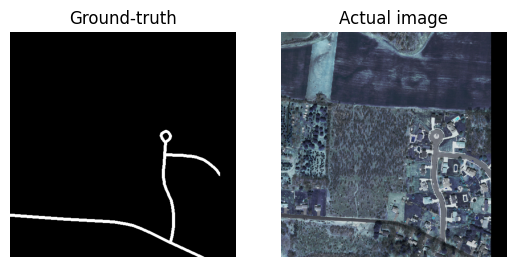

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.figsize = (30,30)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y_train[2]/255,(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax = fig.add_subplot(1,2,2)
ax.imshow(x_train[2]/255)
plt.axis('off')
plt.title("Actual image")

# Loss

In [12]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [13]:
import tensorflow as tf
def create_callbacks():
    # Reduce learning rate on plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,
        patience=10,
        verbose=1,
        cooldown=1,
        min_delta=0.0001
    )

    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.0001,
        patience=30,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )

    # Model checkpoint
    check_path = os.path.join('.', 'efcnet_road.weights.h5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        check_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )

    return [reduce_lr, early_stop, checkpoint]

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    np.save('efcnet_road_history.npy', history.history)

    # Accuracy plot
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], '--', label='val_acc')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], '--', label='val_loss')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.show()



In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score

def get_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc


def evaluate_segmentation(y_test, y_pred):
    # Mean Intersection over Union
    mean_iou = MeanIoU(2)
    mean_iou.update_state(y_test, y_pred)
    class_iou = mean_iou.result().numpy()
    mean_iou.reset_states()
    
    # Accuracy
    acc = Accuracy()
    acc.update_state(y_test, y_pred)
    accuracy = acc.result().numpy()
    acc.reset_states()
    
    # Precision
    precision = precision_score(y_test.ravel(), y_pred.ravel(), average='binary')
    
    # Recall
    recall = recall_score(y_test.ravel(), y_pred.ravel(), average='binary')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
    
    # Classification Report
    cr = classification_report(y_test.ravel(), y_pred.ravel())
    
    # Cohen's Kappa Score
    kappa = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
    
    # Dice Coefficient
    dice_coeff = get_dice(y_test, y_pred)
    mean_dice_coeff = np.mean(dice_coeff)
    
    return {
        "mean_iou": mean_iou,
        "class_iou": class_iou,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm,
        "classification_report": cr,
        "cohen_kappa_score": kappa,
        "dice_coefficient": dice_coeff,
        "mean_dice_coefficient": mean_dice_coeff
    }


In [16]:
import matplotlib.pyplot as plt

def visualize_predictions(x_test, y_test, y_pred, num_samples=10):
    fig = plt.figure(figsize=(100, 100))

    for i in range(num_samples):
        # Plot input image
        ax = fig.add_subplot(num_samples, 3, 3*i+1)
        ax.imshow(np.reshape(x_test[i]/255, (512, 512,3)))
        plt.axis('off')
        plt.title("Input image")

        # Plot ground truth
        ax = fig.add_subplot(num_samples, 3, 3*i+2)
        ax.imshow(np.reshape(y_test[i], (512, 512)), cmap="gray")
        plt.axis('off')
        plt.title("Ground-truth")

        # Plot predicted image
        ax = fig.add_subplot(num_samples, 3, 3*i+3)
        ax.imshow(np.reshape(y_pred[i], (512, 512)), cmap="gray")
        plt.axis('off')
        plt.title("Predicted image")

    plt.tight_layout(pad=0)
    plt.show()

# **EFC Net**

In [17]:
import tensorflow as tf                                                                                                                                                   

In [18]:

class AFM(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AFM, self).__init__(**kwargs)
        # Define the weights for the two-layer neural network
        self.conv2d3x3elu=tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')
        self.gap=tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.seq=tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'),
                               tf.keras.layers.Dense(32, activation='sigmoid')])
    def call(self, inputs):
        x_inputs = self.conv2d3x3elu(inputs)
        #Global avg Pooling
        x = self.gap(x_inputs)
        # Encode features
        h=self.seq(x)

        # Attention weights
        weights = tf.math.multiply(h, x_inputs)
        # Combine and return
        weights = tf.reduce_sum(weights, axis=3)
        return tf.expand_dims(weights, axis=-1)



In [19]:
class SeparableConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, depth_activation=tf.nn.elu, pointwise_activation=None, **kwargs):
        super(SeparableConvBlock, self).__init__(**kwargs)
        self.depthwise = tf.keras.layers.DepthwiseConv2D(kernel_size=3, padding='same')
        self.depth_activation = depth_activation
        self.pointwise = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, use_bias=False, activation=pointwise_activation, padding='same')
    
    def call(self, inputs):
        x = self.depthwise(inputs)
        if self.depth_activation:
            x = self.depth_activation(x)
        x = self.pointwise(x)
        return x


In [20]:
class conv2DElU3x3(tf.keras.layers.Layer):
    def __init__(self, filters=32):
        super(conv2DElU3x3, self).__init__()
        self.conv1=tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation=tf.nn.elu)
        self.conv2=tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation=tf.nn.elu)
        self.filters=filters
    def call(self, inputs):
        #print('input shape, filters', inputs.shape, self.filters)
        x=self.conv1(inputs)
        #print('conv 1', x.shape)
        x=self.conv2(x)
        #print('conv 2', x.shape)
        return x


In [21]:
def conv1x1Sigmoid_layer(inputs, num_classes):
    # Convolutional layer with 1x1 kernel sizeand sigmoid activation
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(inputs)
    return x

In [22]:
def create_model(num_classes, image_size=(512, 512, 3)):
    inputs = tf.keras.Input(shape=image_size)
    
    layer1=conv2DElU3x3(32)
    layer2=conv2DElU3x3(64)
    layer3=conv2DElU3x3(128)
    layer4=conv2DElU3x3(256)
    layer5=conv2DElU3x3(512)

    print('input shape', inputs.shape)
    layer1_out = layer1(inputs)
    print('layer1_out shape', layer1_out.shape)
    out2= conv1x1Sigmoid_layer(layer1_out,1)
    print('out2 shape', out2.shape)
    x = tf.keras.layers.MaxPooling2D((2,2))(layer1_out)
    print('max pool shape', x.shape)

    
    layer2_out = layer2(x)
    print('layer2_out shape', layer2_out.shape)
    x = tf.keras.layers.MaxPooling2D((2,2))(layer2_out)
    print('max pool shape', x.shape)
    y4 = tf.keras.layers.UpSampling2D((2,2))(layer2_out)
    print('up pool shape', y4.shape)
    
    layer3_out = layer3(x)
    print('layer3_out shape', layer3_out.shape)
    x = tf.keras.layers.MaxPooling2D((2,2))(layer3_out)
    print('max pool shape', x.shape)
    y3 = tf.keras.layers.UpSampling2D((2,2))(layer3_out)
    print('up pool shape', y3.shape)
    
    layer4_out = layer4(x)
    print('layer4_out shape', layer4_out.shape)
    x = tf.keras.layers.MaxPooling2D((2,2))(layer4_out)
    print('max pool shape', x.shape)
    y2 = tf.keras.layers.UpSampling2D((2,2))(layer4_out)
    print('up pool shape', y2.shape)    
    
    layer5_out = layer5(x)
    print('layer5_out shape', layer5_out.shape)
    y1 = tf.keras.layers.UpSampling2D((2,2))(layer5_out)
    print('up pool shape', y1.shape)
    
    layer1=conv2DElU3x3(32)
    layer2=conv2DElU3x3(64)
    layer3=conv2DElU3x3(128)
    layer4=conv2DElU3x3(256)
    
    con_out = tf.keras.layers.Concatenate()([y1, layer4_out])
    decoder1_out=layer4(con_out)
    
    y6 = tf.keras.layers.UpSampling2D((2,2))(decoder1_out)
    print('up pool shape', y6.shape)
    
    con_out = tf.keras.layers.Concatenate()([y6, layer3_out])
    decoder2_out=layer3(con_out)
    
    y7 = tf.keras.layers.UpSampling2D((2,2))(decoder2_out)
    print('up pool shape', y7.shape)
    
    con_out = tf.keras.layers.Concatenate()([y7, layer2_out])
    decoder3_out=layer2(con_out)
    
    y8 = tf.keras.layers.UpSampling2D((2,2))(decoder3_out)
    print('up pool shape', y8.shape)
    
    con_out = tf.keras.layers.Concatenate()([y8, layer1_out])
    decoder4_out=layer1(con_out)
    
    out1=conv1x1Sigmoid_layer(decoder4_out,1)
    print('out1 shape', out1.shape)
    
    
    
    con_out3 = tf.keras.layers.Concatenate()([y2, layer3_out])
    scm=SeparableConvBlock(128)
    con_out3=scm(con_out3)
    y9=tf.keras.layers.UpSampling2D((2,2))(con_out3)
    
    con_out4 = tf.keras.layers.Concatenate()([y9, layer2_out])
    scm=SeparableConvBlock(64)
    con_out4=scm(con_out4)
    y10=tf.keras.layers.UpSampling2D((2,2))(con_out4)
    
    con_out5 = tf.keras.layers.Concatenate()([y10, layer1_out])
    scm=SeparableConvBlock(32)
    con_out5=scm(con_out5)
    out3=conv1x1Sigmoid_layer(con_out5, 1)
    print('out3 shape', out3.shape)
    
    
    
    
    con_out21 = tf.keras.layers.Concatenate()([y3, layer2_out])
    scm=SeparableConvBlock(128)
    con_out21=scm(con_out21)
    y11=tf.keras.layers.UpSampling2D((2,2))(con_out21)
    
    con_out22 = tf.keras.layers.Concatenate()([y11, layer1_out])
    scm=SeparableConvBlock(64)
    con_out22=scm(con_out22)
    out4=conv1x1Sigmoid_layer(con_out22, 1)
    print('out4 shape', out4.shape)
    
    con_out1 = tf.keras.layers.Concatenate()([y4, layer1_out])
    scm=SeparableConvBlock(32)
    con_out1=scm(con_out1)
    out5=conv1x1Sigmoid_layer(con_out1, 1)
    print('out5 shape', out5.shape)
    
    
    out_concat= tf.keras.layers.Concatenate()([out1, out2, out3,out4,out5])
    outputs=AFM()(out_concat)
    print(outputs.shape)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model
    
  # # Initial block
 

  # # SCM + AFM stages
  # for filters in [64, 128, 256]:
  #   x = SeparableConvBlock(filters=filters, depth_activation=tf.nn.elu)(x)
  #   x = AFM()(x)
  #   x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

  # # Flatten and classification head
  # x = tf.keras.layers.GlobalAveragePooling2D()(x)
  # outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

 

In [23]:
model= create_model(1, (512, 512, 3))
model.summary()

input shape (None, 512, 512, 3)
layer1_out shape (None, 512, 512, 32)
out2 shape (None, 512, 512, 1)
max pool shape (None, 256, 256, 32)
layer2_out shape (None, 256, 256, 64)
max pool shape (None, 128, 128, 64)
up pool shape (None, 512, 512, 64)
layer3_out shape (None, 128, 128, 128)
max pool shape (None, 64, 64, 128)
up pool shape (None, 256, 256, 128)
layer4_out shape (None, 64, 64, 256)
max pool shape (None, 32, 32, 256)
up pool shape (None, 128, 128, 256)
layer5_out shape (None, 32, 32, 512)
up pool shape (None, 64, 64, 512)
up pool shape (None, 128, 128, 256)
up pool shape (None, 256, 256, 128)
up pool shape (None, 512, 512, 64)
out1 shape (None, 512, 512, 1)
out3 shape (None, 512, 512, 1)
out4 shape (None, 512, 512, 1)
out5 shape (None, 512, 512, 1)
(None, 512, 512, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 

In [24]:
from tensorflow.keras.losses import binary_crossentropy

def dice_loss(y_true, y_pred):
    smooth = 1
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


In [25]:
def weighted_cross_entropy(beta):
    def loss(y_true, y_pred):
        weight_a = beta * tf.cast(y_true, tf.float32)
        weight_b = 1 - tf.cast(y_true, tf.float32)
    
        o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
        return tf.reduce_mean(o)
    return loss

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

def weighted_BCE_loss(y_true, y_pred, positive_weight=5):
    # Clipping y_pred
    y_pred = tf.clip_by_value(y_pred, clip_value_min=1e-12, clip_value_max=1 - 1e-12)
    weights = tf.ones_like(y_pred)  # (None, 512, 512, 1)
    weights = tf.where(y_pred >= 0.5, positive_weight * weights, weights)
    out = keras.losses.binary_crossentropy(y_true, y_pred)  # (None, 512, 512)
    out = tf.expand_dims(out, axis=-1) * weights  # (None, 512, 512, 1) * (None, 512, 512, 1)
    return tf.reduce_mean(out)


In [29]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-08)
opt = tf.keras.optimizers.Adam()
#model.compile(optimizer=opt, loss=bce_dice_loss, metrics=['accuracy'])
#model.compile(optimizer=opt, loss=weighted_BCE_loss, metrics=['accuracy'])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
# from tensorflow.keras.losses import BinaryCrossentropy

# def weighted_binary_cross_entropy(y_true, y_pred, class_weights):
#     # Convert class weights to tensor
#     class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
    
#     # Compute weighted binary cross-entropy
#     bce = BinaryCrossentropy()
#     weighted_bce = tf.reduce_mean(class_weights_tensor * bce(y_true, y_pred))
    
#     return weighted_bce

# # Define class weights
# class_weights = [1.0, 2.0]

# # Compile the model with the weighted binary cross-entropy loss
# model.compile(optimizer=opt, loss=lambda y_true, y_pred: weighted_binary_cross_entropy(y_true, y_pred, class_weights), metrics=['accuracy'])


In [30]:
callbacks = create_callbacks()
history = model.fit(train_gen, validation_data=val_gen, batch_size=1,shuffle=True, verbose=1
                                  ,epochs = 40, callbacks = callbacks )


Epoch 1/40
2700/2700 [==============================] - ETA: 0s - loss: 0.5867 - accuracy: 0.9619
Epoch 00001: val_loss improved from inf to 1.01501, saving model to .\efcnet_road.weights.h5
2700/2700 [==============================] - 1722s 634ms/step - loss: 0.5867 - accuracy: 0.9619 - val_loss: 1.0150 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 2/40
2700/2700 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.9622
Epoch 00002: val_loss did not improve from 1.01501
2700/2700 [==============================] - 1712s 634ms/step - loss: 0.5830 - accuracy: 0.9622 - val_loss: 1.0150 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 3/40
2700/2700 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.9622
Epoch 00003: val_loss did not improve from 1.01501
2700/2700 [==============================] - 1715s 635ms/step - loss: 0.5830 - accuracy: 0.9622 - val_loss: 1.0150 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 4/40
2700/2700 [==============================] - ET

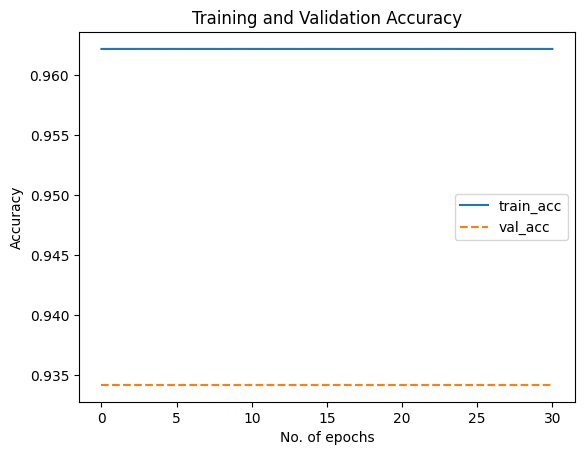

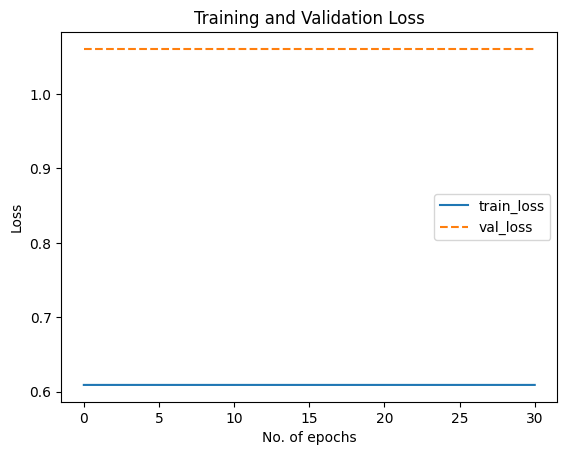

In [86]:
plot_history(history)

In [87]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
#https://github.com/tokusumi/keras-flops/blob/master/notebooks/flops_calculation_tfkeras.ipynb
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

flops = get_flops(model)
flops

TypeError: can only concatenate list (not "tuple") to list

In [ ]:
#model.load_weights("/kaggle/working/macunet_building.weights.h5")

In [31]:
y_predicted=[]
for i in range(len(x_test)):
    image= np.expand_dims(x_test[i], axis=0)

    y_pred = model.predict(image)
    y_pred=y_pred>0.5
    y_predicted.append(y_pred)

In [32]:
def combine_images_gray(images, num_samples=9):
    # Create an empty array to store the combined image
    combined_image = np.zeros((1536, 1536))

    # Calculate the number of rows and columns for the grid
    rows = int(np.ceil(np.sqrt(num_samples)))
    cols = int(np.ceil(num_samples / rows))

    # Iterate over the images and place them in the combined image array
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        start_row = row * 512
        end_row = start_row + 512
        start_col = col * 512
        end_col = start_col + 512
        combined_image[start_row:end_row, start_col:end_col] = images[i].squeeze() / 255

    return combined_image

In [33]:
def combine_images_rgb(images, num_samples=9):
    # Create an empty array to store the combined image
    combined_image = np.zeros((1536, 1536,3))

    # Calculate the number of rows and columns for the grid
    rows = int(np.ceil(np.sqrt(num_samples)))
    cols = int(np.ceil(num_samples / rows))

    # Iterate over the images and place them in the combined image array
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        start_row = row * 512
        end_row = start_row + 512
        start_col = col * 512
        end_col = start_col + 512
        combined_image[start_row:end_row, start_col:end_col] = images[i] / 255

    return combined_image


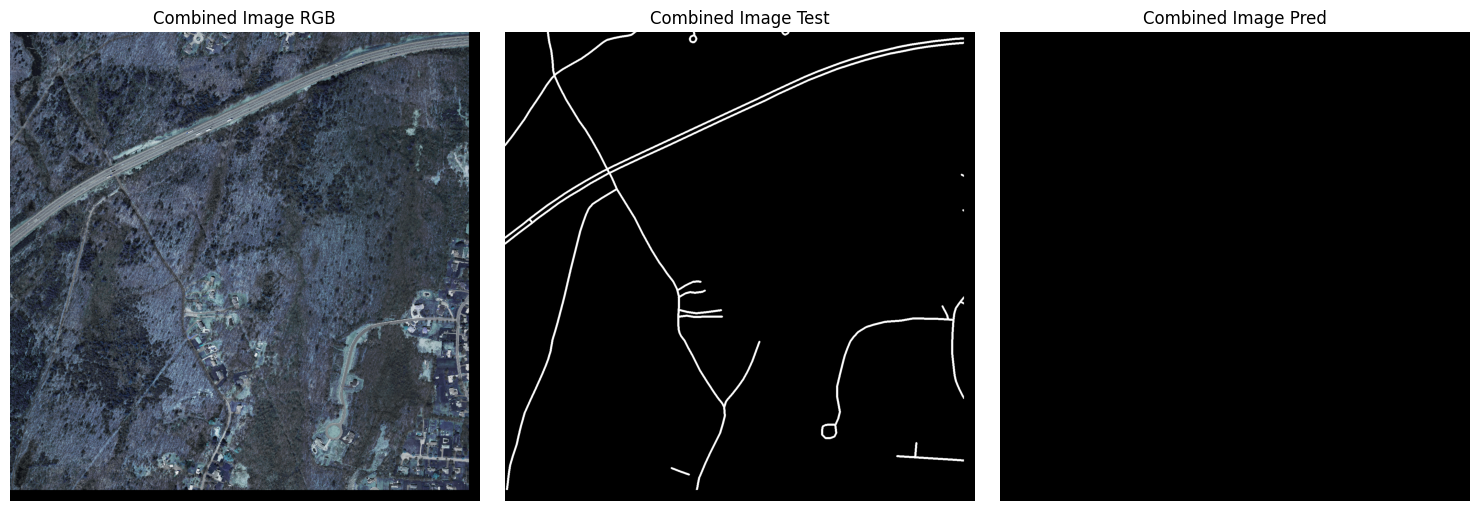

In [34]:
combined_image_rgb = combine_images_rgb(x_test[0:9])
combined_image_test = combine_images_gray(y_test[0:9])
combined_image_pred = combine_images_gray(y_predicted[0:9])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plotting the first image
axes[2].imshow(combined_image_pred, cmap='gray')
axes[2].set_title('Combined Image Pred')
axes[2].axis('off')

# Plotting the second image
axes[1].imshow(combined_image_test, cmap='gray')
axes[1].set_title('Combined Image Test')
axes[1].axis('off')

# Plotting the third image
axes[0].imshow(combined_image_rgb)
axes[0].set_title('Combined Image RGB')
axes[0].axis('off')
plt.savefig('output_efc_road.png')
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

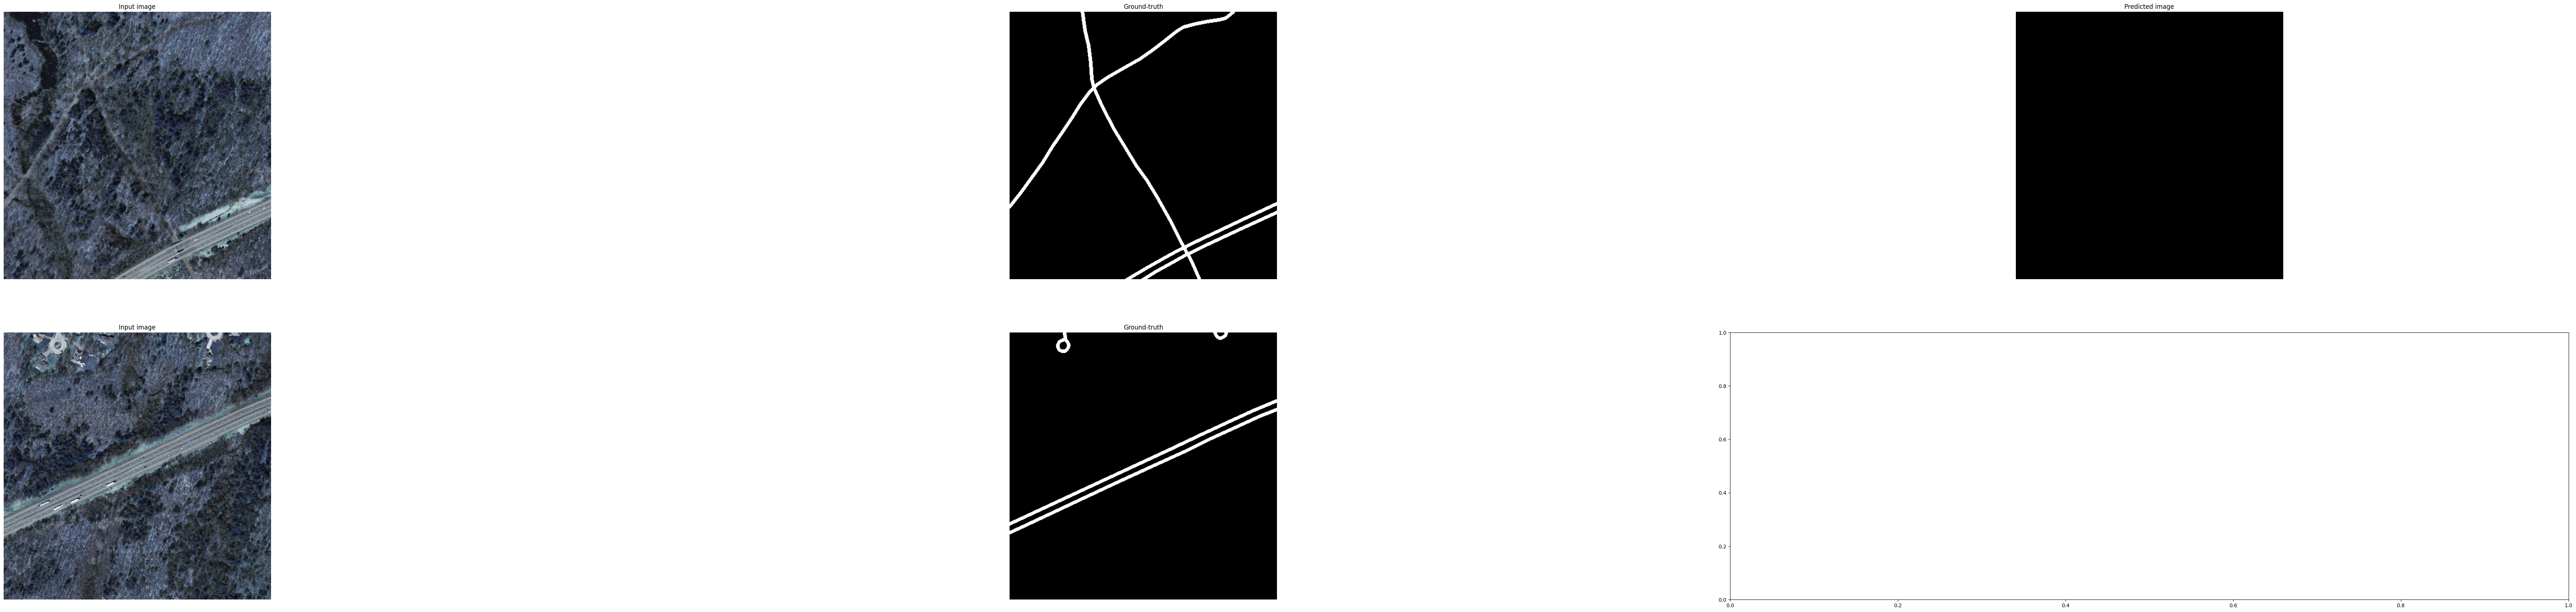

In [35]:
visualize_predictions(x_test, y_test, y_pred, num_samples=9)

In [ ]:
from sklearn.metrics import *
def dice_coefficient(jaccard):
    #jaccard = jaccard_score(y_true.flatten(), y_pred.flatten())
    return 2*jaccard / (1 + jaccard)

gt = (y_test.ravel()).astype('int')
pd = (np.array(y_predicted).ravel()).astype('int')

f1 = f1_score(gt, pd, average='macro')
kappa = cohen_kappa_score(gt, pd)
accuracy = accuracy_score(gt, pd)
jaccard = jaccard_score(gt, pd, average='macro')
precision = precision_score(gt, pd, average='macro')
recall = recall_score(gt, pd, average='macro')
dice = dice_coefficient(jaccard)

print("F1 SCORE:", f1)
print("Kappa:", kappa)
print("Accuracy:", accuracy)
print("Jaccard Score:", jaccard)
print("Precision:", precision)
print("Recall:", recall)
print("Dice Coefficient:", dice)



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 SCORE: 0.48854059188157983
Kappa: 0.0
Accuracy: 0.95518937402842
Jaccard Score: 0.47759468701421
Precision: 0.47759468701421
Recall: 0.5
Dice Coefficient: 0.6464488417717449
